<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/Topic_11__RNN_GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Завантаження бібліотек***

In [1]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

Визначимо шлях до даних і пристрій, на якому будемо проводити розрахунки.

In [4]:
data_path = '/content/drive/MyDrive/DeepLearningforComputervisionandNLP/conll003-englishversion/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


будемо зчитувати тільки елементи на позиції 0 — слова — і 3 — мітки іменованих сутностей. У коді це буде відображатися так: sentences.append((l[0], l[3].strip('\\n'))).

In [9]:
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    return final

train_sents = load_sentences(data_path + 'train.txt')
test_sents = load_sentences(data_path + 'test.txt')
val_sents = load_sentences(data_path + 'valid.txt')

train_sents[:3]


[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('Peter', 'B-PER'), ('Blackburn', 'I-PER')],
 [('BRUSSELS', 'B-LOC'), ('1996-08-22', 'O')]]

Визначимо список міток класів і закодуємо їх для чисельного представлення.

In [11]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}


Представимо наші завантажені речення як словник, де під ключем text будуть зберігатися наші речення, а під ключем label — відповідні мітки іменованих сутностей.

In [12]:
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}


train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)

Для подальшої роботи з даними нам потрібно представити їх у чисельній формі.

Спочатку побудуємо словник. Для цього спершу підрахуємо кількість появи кожного слова в корпусі.

In [13]:
word_dict = defaultdict(int)

for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

Ми не будемо використовувати слова, які дуже рідко з’являються, для тренування. Таким чином, ми зменшимо кількість неінформативних ознак у наборі даних.

In [14]:
lower_freq_word = []
for k,v in word_dict.items():
    if v < 2:
        lower_freq_word.append(k)

for word in lower_freq_word:
    del word_dict[word]

***Додамо до словника два спеціальні токени.***

Перший токен <UNK> позначатиме всі слова, які не присутні у словнику, так звані Out Of Vocabulary words, OOV words

Другий токен <PAD> позначає падинг (padding). Оскільки речення в наборі даних можуть мати різну довжину, необхідно забезпечити, щоб усі вхідні послідовності мали однакову довжину для обробки батчами (batch processing). Це досягається шляхом додавання спеціальних символів — падингів — до коротших послідовностей.

In [15]:
word_dict['<UNK>'] = -1
word_dict['<PAD>'] = -2


створюємо словник, який буде містити слово та його індекс. Ми будемо використовувати цей словник, щоб представити наші речення в числовому вигляді для подальшої обробки нейронною мережею.

In [17]:
word2id = {}

for idx, word in enumerate(word_dict.keys()):
  word2id[word] = idx


# ***Dataset і DataLoader***

Створимо допоміжну функцію, якою будемо кодувати речення в числовий формат. Якщо слово є в нашому словнику, ми будемо замінювати його на відповідне значення зі словника.

Якщо ж слово не присутнє у словнику — будемо повертати числове значення, що позначає токен <UNK>.

In [18]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])
    return idxs

Опишемо клас Dataset, необхідний для абстракції та організації даних під час навчання моделі. Він дозволяє легко керувати даними, завантажувати їх і забезпечує доступ до окремих прикладів даних і їхніх міток.

In [19]:
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

Для тренування поточної моделі нам необхідно визначити collate-функцію.

Наприкінці перетворюємо наші дані в torch.tensor для подальшої роботи з фреймворком PyTorch.

In [20]:
class Collate:
    def __init__(self, train):
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        if self.train:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding

        output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]
        if self.train:
            output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        if self.train:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)

        return output

collate_fn = Collate(True)


# ***Клас моделі***

1. embeddings — шар ембедингів.


2. lstm — шар, який відповідає за Bi-LSTM-компонент у нашій мережі.


 - embedding_dim визначає розмірність вхідних векторів.

 - hidden_dim визначає розмірність прихованих станів і вихідного тензора.

 - bidirectional робить LSTM двонаправленою.

 - num_layers дозволяє створити глибоку модель з трьома послідовними LSTM-шарами.

 - batch_first вказує, що перший розмір вхідного тензора відповідає розміру батчу, що полегшує обробку даних у батчах.

 - fc створює повнозв'язний (лінійний) шар.

 - output_size визначає кількість нейронів у вихідному шарі, що відповідає кількості класів у задачі класифікації.



In [21]:
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()

        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)

        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)

        # 3. Dense Layer
        self.fc = nn.Linear(2*hidden_dim, output_size)

    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)

        lstm_output, _ = self.lstm(embeddings)

        logits = self.fc(lstm_output)
        return logits


Допоміжні функції для тренування

Спершу визначимо функцію remove_predictions_for_masked_items.

Оскільки нас цікавить тільки якість передбачення для міток іменованих сутностей, будемо прибирати з результатів токени зі значенням, меншим за 0.

In [22]:
def remove_predictions_for_masked_items(predicted_labels, correct_labels):

    predicted_labels_without_mask = []
    correct_labels_without_mask = []

    for p, c in zip(predicted_labels, correct_labels):
        if c > 0:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)

    return predicted_labels_without_mask, correct_labels_without_mask

Тепер визначимо функцію, відповідальну за навчання й валідацію. Як валідаційну метрику використаємо macro F1.

In [23]:
def train(model, train_loader, val_loader, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # we mask the <pad> labels
    optimizer = Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        model.train()
        for batch in tqdm(train_loader, total=num_batches, desc=f"Epoch {epoch}"):

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            loss = criterion(pred, gold)

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)

            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels,
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels

        train_score = f1_score(correct, predictions, average="macro")
        train_f_score_history.append(train_score)

        print("Total training loss:", total_loss)
        print("Training Macro F1:", train_score)

        total_loss = 0
        predictions, correct = [], []

        model.eval()
        with torch.no_grad():
            for batch in val_loader:

                cur_batch_size, text_length = batch['input_ids'].shape

                pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
                gold = batch['labels'].to(device).view(cur_batch_size*text_length)

                loss = criterion(pred, gold)
                total_loss += loss.item()

                _, pred_indices = torch.max(pred, 1)
                predicted_labels = list(pred_indices.cpu().numpy())
                correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

                predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels,
                                                                                       correct_labels)

                predictions += predicted_labels
                correct += correct_labels

        dev_score = f1_score(correct, predictions, average="macro")

        print("Total validation loss:", total_loss)
        print("Validation Macro F1:", dev_score)

        dev_f = dev_score
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0

        if no_improvement > patience:
            print("Validation F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break

        dev_f_score_history.append(dev_f)

    return train_f_score_history, dev_f_score_history

☝ Зверніть увагу, тут ми додаємо механізм ранньої зупинки тренування.

Визначимо функцію для тестування

In [24]:
def test(model, test_iter, batch_size, labels, target_names):
    total_loss = 0
    predictions, correct = [], []

    model.eval()
    with torch.no_grad():

        for batch in test_iter:

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels,
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels

    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

# ***Тренування моделі***

Спершу визначимо гіперпараметри моделі.

In [49]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_CLASSES = len(id2label)
MAX_EPOCHS = 50
PATIENCE = 3
BATCH_SIZE = 32
VOCAB_SIZE = len(word2id)
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_df) / BATCH_SIZE)


Створимо об’єкти Dataset і DataLoader.

In [50]:
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

val_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

test_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)


Створимо об’єкт моделі.

In [51]:
tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)
tagger


BiLSTMTagger(
  (embeddings): Embedding(11986, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

# ***Нарешті, переходимо до тренування!***


In [52]:
train_f, dev_f = train(tagger.to(device), train_loader, val_loader, BATCH_SIZE, MAX_EPOCHS,
                       num_batches, PATIENCE, OUTPUT_PATH)

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 269.75962299108505
Training Macro F1: 0.13435005076478493
Total validation loss: 37.5171083509922
Validation Macro F1: 0.31873984087969653
Saving model.


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 111.46009000390768
Training Macro F1: 0.48237156518458085
Total validation loss: 23.103755690157413
Validation Macro F1: 0.603285968584268
Saving model.


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 59.52654993906617
Training Macro F1: 0.702774294629344
Total validation loss: 20.043051664717495
Validation Macro F1: 0.6637074640665831
Saving model.


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 35.44090577401221
Training Macro F1: 0.7801158344701987
Total validation loss: 17.778083734912798
Validation Macro F1: 0.708408715316913
Saving model.


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 22.629682906903327
Training Macro F1: 0.8268978049176298
Total validation loss: 16.360637578298338
Validation Macro F1: 0.7328667079633737
Saving model.


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 15.792949415976182
Training Macro F1: 0.8469380709687143
Total validation loss: 18.561066332971677
Validation Macro F1: 0.7127816614870134


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 11.733246926916763
Training Macro F1: 0.858656805161372
Total validation loss: 18.58855002198834
Validation Macro F1: 0.7306304685971922


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 8.207983836415224
Training Macro F1: 0.8699149838429886
Total validation loss: 19.91203910240438
Validation Macro F1: 0.7268253750978442


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 6.64335283706896
Training Macro F1: 0.8732967464848675
Total validation loss: 21.448940275033237
Validation Macro F1: 0.7103341300243959
Validation F-score does not improve anymore. Stop training.


Візуалізуємо навчальну й валідаційну метрики.

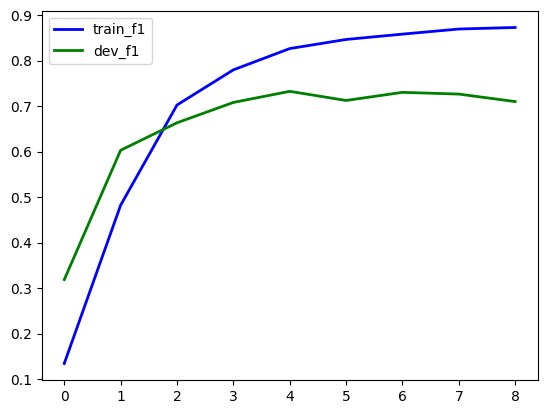

In [59]:
df = pd.DataFrame({'epochs': range(0,len(train_f)),
                  'train_f1': train_f,
                   'dev_f1': dev_f})

plt.plot('epochs', 'train_f1', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f1', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


Перевіримо якість моделі на тестовому наборі даних. Завантажимо кращу зі збережених моделей.

In [60]:
tagger = torch.load(OUTPUT_PATH, weights_only=False)

Виконаємо перевірку.

In [61]:
labels = list(label2id.keys())[1:]
label_idxs = list(label2id.values())[1:]

test(tagger, test_loader, BATCH_SIZE, labels = label_idxs, target_names = labels)


              precision    recall  f1-score   support

       B-PER       0.87      0.69      0.77      1617
       I-PER       0.90      0.78      0.84      1156
       B-ORG       0.82      0.64      0.72      1661
       I-ORG       0.84      0.70      0.77       835
       B-LOC       0.90      0.79      0.84      1668
       I-LOC       0.82      0.62      0.70       257
      B-MISC       0.80      0.63      0.70       702
      I-MISC       0.80      0.59      0.68       216

   micro avg       0.86      0.70      0.77      8112
   macro avg       0.84      0.68      0.75      8112
weighted avg       0.86      0.70      0.77      8112

